# Imports

In [266]:
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import talos
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from time import sleep
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, TimeDistributed, LSTM, Lambda
from tensorflow.keras import regularizers
import tensorflow as tf

# Load data
load hospitalisations and trends for Belgium and France

In [267]:
# topics considered
list_topics = {
    'Fièvre': '/m/0cjf0',
    'Mal de gorge': '/m/0b76bty',
    'Dyspnée': '/m/01cdt5',
    'Agueusie': '/m/05sfr2',
    'Anosmie': '/m/0m7pl',
    'Coronavirus': '/m/01cpyy',
    'Virus': '/m/0g9pc',
    #'Température corporelle humaine': '/g/1213j0cz',
    'Épidémie': '/m/0hn9s',
    'Symptôme': '/m/01b_06',
    'Thermomètre': '/m/07mf1',
    'Grippe espagnole': '/m/01c751',
    'Paracétamol': '/m/0lbt3',
    'Respiration': '/m/02gy9_',
    'Toux': '/m/01b_21'
}

geocodes = {
    'BE': "Belgique",
    'FR-A': "Alsace-Champagne-Ardenne-Lorraine",
    'FR-B': "Aquitaine-Limousin-Poitou-Charentes",
    'FR-C': "Auvergne-Rhône-Alpes",
    'FR-J': 'Ile-de-France'
}

In [268]:
date_begin = "2020-02-01"

def diff_percentage(list_values):
    new_list_values = [0]
    for i in range(1, len(list_values)):
        diff = list_values[i] - list_values[i-1]
        if diff == 0 or list_values[i] == 0:
            new_list_values.append(0)
        else:
            if list_values[i-1] == 0 and list_values[i] != 0:
                new_list_values.append(1.0)
            else:
                diff = diff / list_values[i-1]
                new_list_values.append(diff)
    # Normalization between 0 and 1
    new_list_values = [(x-min(new_list_values))/(max(new_list_values)-min(new_list_values)) for x in new_list_values]
    return new_list_values
        

def create_dataframe_hospi(hospi_france, hospi_belgium, department_france, geo, percentage=True, total=True):
    """
    Creates the dataframe containing the number of daily new hospitalizations
    with respect to the date and the localisation (FR and BE)
    """
    departements = pd.read_csv(department_france)
    hospitalisations = pd.read_csv(hospi_france, sep=";")
    data_fr = hospitalisations.join(departements.set_index('departmentCode'), on="dep").groupby(["regionName", "jour"],
                                                                                                as_index=False).agg(
        {"hosp": "sum"})
    data_fr = data_fr.rename(columns={"jour": "DATE", "hosp": "HOSP", "regionName": "LOC"})
    
    # Belgian data
    data_be = pd.read_csv(hospi_belgium).groupby(["DATE"]).agg({"TOTAL_IN": "sum"}).reset_index().rename(
        columns={"TOTAL_IN": "HOSP"})
    data_be["LOC"] = "Belgique"
    
    if total:
        data_fr["TOT_HOSP"] = data_fr['HOSP']
        data_be["TOT_HOSP"] = data_be['HOSP']

    # Full data
    full_data = data_fr.append(data_be).set_index(["LOC", "DATE"])

    # find smallest date for each loc
    smallest = {}
    for loc, date_current in full_data.index:
        if loc not in smallest or smallest[loc] > date_current:
            smallest[loc] = date_current

    base_date = datetime.strptime(date_begin, "%Y-%m-%d").date()

    # Add "fake" data (zeroes before the beginning of the crisis) for each loc
    toadd = []
    for loc, sm in smallest.items():
        end = datetime.strptime(sm, "%Y-%m-%d").date()
        cur = base_date

        while cur != end:
            toadd.append([cur.strftime("%Y-%m-%d"), loc, 0])
            cur += timedelta(days=1)
            
    full_data = pd.DataFrame(toadd, columns=["DATE", "LOC", "HOSP"]).append(full_data.reset_index()).set_index(
        ["LOC", "DATE"])
    data_dic = {}
    for k, v in geo.items():
        data_dic[k] = full_data.iloc[full_data.index.get_level_values('LOC') == v]
        if percentage:
            new_list_hospi = diff_percentage(data_dic[k]['HOSP'])
            data_dic[k]['HOSP'] = new_list_hospi
        data_dic[k]['TOT_HOSP'] = data_dic[k]['TOT_HOSP'].fillna(0.0)
    return data_dic


def create_df_trends(url_trends, geo, percentage=True, total=True):
    """
    return dic of {geo: df} for the trends
    """
    renaming = {v: k for k, v in list_topics.items()}  # change topic_mid to topic_title in the dataframe
    result = {}
    for k, v in geo.items():
        all_trends = []
        for term in list_topics.keys():
            path = f"{url_trends}{k}-{term}.csv"
            encoded_path = requests.get(path).content
            df_trends = pd.read_csv(io.StringIO(encoded_path.decode("utf-8"))).rename(columns={"date": "DATE"})
            df_trends['LOC'] = v
            df_trends.rename(columns=renaming, inplace=True)
            df_trends.set_index(['LOC', 'DATE'], inplace=True)
            if total:
                df_trends[f"total_{term}"] = df_trends[term]
            if percentage:
                new_list_trends = diff_percentage(df_trends[term])
                df_trends[term] = new_list_trends
            all_trends.append(df_trends)
        result[k] = pd.concat(all_trends, axis=1)
    return result

--------------------BE-----------------------


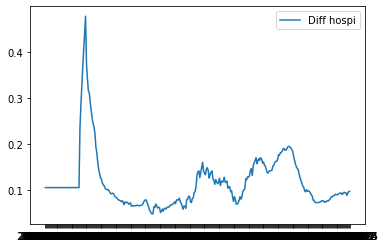

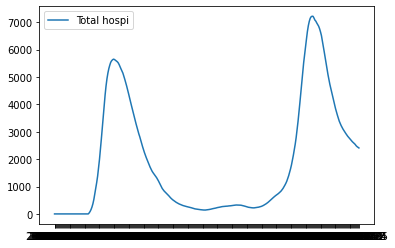

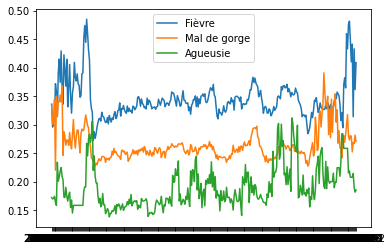

--------------------FR-A-----------------------


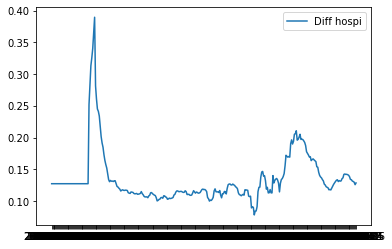

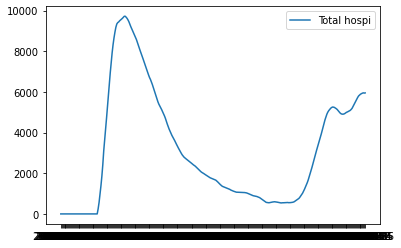

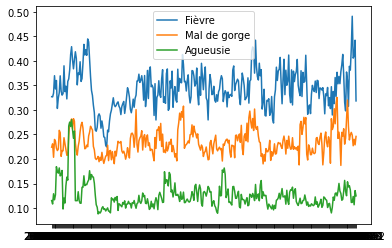

--------------------FR-B-----------------------


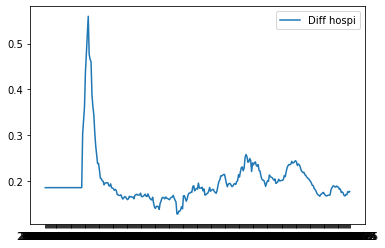

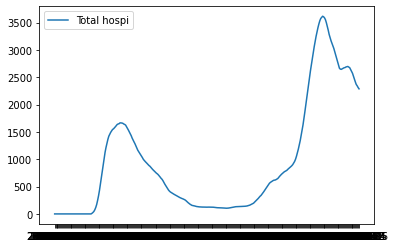

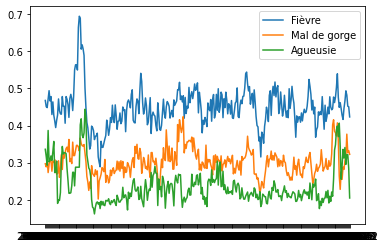

--------------------FR-C-----------------------


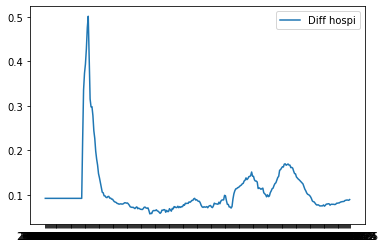

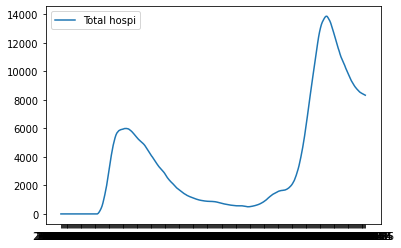

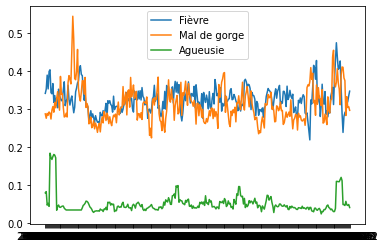

--------------------FR-J-----------------------


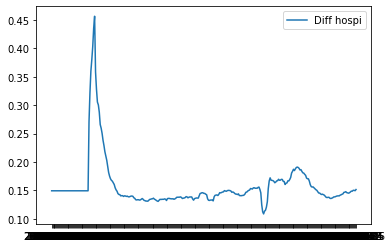

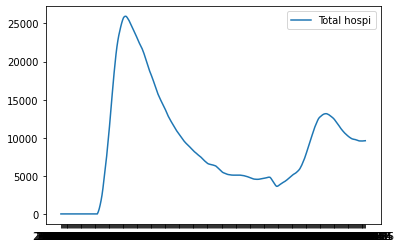

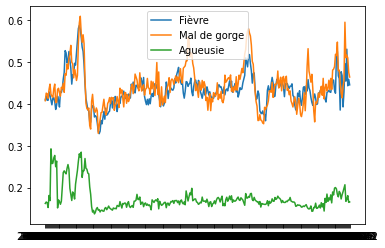

In [269]:
url_trends = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/trends/model/"
url_hospi_belgium = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/be-covid-hospi.csv"
url_department_france = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/src/france_departements.csv"
url_hospi_france = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/fr-covid-hospi-total.csv"
# Percentage is True if we want to take the difference of variation between today and yesterday in percentage
# Total is True if we want to add the absolute total value to the input of the model
df_trends = create_df_trends(url_trends, geocodes, percentage=True, total=True)
df_hospi = create_dataframe_hospi(url_hospi_france, url_hospi_belgium, url_department_france, geocodes, percentage=True, total=True)
for k in geocodes.keys():
    # Rolling average of 7 days 
    df_hospi[k] = df_hospi[k].rolling(7, center=True).mean().dropna()
    df_trends[k] = df_trends[k].rolling(7, center=True).mean().dropna()
    print(f"--------------------{k}-----------------------")
    plt.figure()
    plt.plot(df_hospi[k]['HOSP'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Diff hospi')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(df_hospi[k]['TOT_HOSP'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Total hospi')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(df_trends[k]['Fièvre'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Fièvre')
    plt.plot(df_trends[k]['Mal de gorge'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Mal de gorge')
    plt.plot(df_trends[k]['Agueusie'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Agueusie')
    plt.legend()
    plt.show()

#df_hospi

# Preprocess data

## Days used for the forecast
Each forecast is done for `n_forecast` days and uses `n_samples` days before to construct the prediction

In [270]:
n_forecast = 3  # Number of days we want to predict
n_samples = 14  # Number of days used to make the prediction
shift_hospi = 1  # delay between a date and its newest hosp value for this date 
# (ex: 26/10's newest value is for 25/10)
shift_trends = 3  # delay between a date and its newest trends value for this date 

## Add lag

In [271]:
def timeseries_shift(data, lag, dropna=True):
    """
    Changes all columns with their shifted data
    """
    return data.shift(lag).dropna()

for k in geocodes.keys():
    df_hospi[k] = timeseries_shift(df_hospi[k], shift_hospi)
    df_trends[k] = timeseries_shift(df_trends[k], shift_trends)

In [272]:
def timeseries_add_lag(data, lag, dropna=True):
    """
    Adds lagged values to dataframe
    """
    df = pd.DataFrame(data)
    init_columns = df.columns
    columns = [df.shift(i) for i in range(lag-1, 0, -1)]
    renaming = {}  # rename the columns
    delay = lag-1
    for i in range(lag-1):
        for k in init_columns:
            renaming[k] = f'{k}(t-{delay})'
        columns[i].rename(columns=renaming ,inplace=True)
        delay -= 1
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df.dropna() if dropna else df


merged_df = {k: pd.merge(df_hospi[k], df_trends[k], left_index=True, right_index=True).dropna() for k,v in geocodes.items()}
n_features = len(merged_df['BE'].columns)
for k in geocodes.keys():
    merged_df[k] = timeseries_add_lag(merged_df[k], n_samples)

merged_df['BE']


HOSP(t-13)  TOT_HOSP(t-13)  Fièvre(t-13)  \
LOC      DATE                                                   
Belgique 2020-02-20    0.106145        0.000000      0.336011   
         2020-02-21    0.106145        0.000000      0.295878   
         2020-02-22    0.106145        0.000000      0.310932   
         2020-02-23    0.106145        0.000000      0.310598   
         2020-02-24    0.106145        0.000000      0.371953   
...                         ...             ...           ...   
         2020-12-18    0.080485     3386.714286      0.357164   
         2020-12-19    0.085383     3305.142857      0.354071   
         2020-12-20    0.085260     3225.714286      0.350915   
         2020-12-21    0.088341     3160.571429      0.335658   
         2020-12-22    0.088117     3096.000000      0.307320   

                     total_Fièvre(t-13)  Mal de gorge(t-13)  \
LOC      DATE                                                 
Belgique 2020-02-20           19.969895            0.333832   
         2020-02-21           18.600817            0.300627   
         2020-02-22           17.625977            0.307704   
         2020-02-23           16.751487            0.344336   
         2020-02-24           17.367931            0.220252   
...                                 ...                 ...   
         2020-12-18           12.924299            0.325983   
         2020-12-19           13.178190            0.267614   
         2020-12-20           13.377885            0.289352   
         2020-12-21           13.272805            0.259494   
         2020-12-22           12.661225            0.259369   

                     total_Mal de gorge(t-13)  Dyspnée(t-13)  \
LOC      DATE                                                  
Belgique 2020-02-20                 23.555261       0.290931   
         2020-02-21                 21.739491       0.317214   
         2020-02-22                 21.109361       0.252405   
         2020-02-23                 22.071138       0.244660   
         2020-02-24                 17.651936       0.254018   
...                                       ...            ...   
         2020-12-18                 23.083824       0.158900   
         2020-12-19                 22.045785       0.162819   
         2020-12-20                 22.867650       0.171372   
         2020-12-21                 22.427401       0.165629   
         2020-12-22                 22.102597       0.148992   

                     total_Dyspnée(t-13)  Agueusie(t-13)  \
LOC      DATE                                              
Belgique 2020-02-20            21.522456        0.172283   
         2020-02-21            24.965976        0.170102   
         2020-02-22            25.187223        0.170439   
         2020-02-23            24.459801        0.174459   
         2020-02-24            25.185404        0.164479   
...                                  ...             ...   
         2020-12-18            29.561563        0.224664   
         2020-12-19            30.039509        0.224664   
         2020-12-20            32.135778        0.224664   
         2020-12-21            32.052489        0.209742   
         2020-12-22            29.632790        0.235250   

                     total_Agueusie(t-13)  ...  Thermomètre  \
LOC      DATE                              ...                
Belgique 2020-02-20              1.884188  ...     0.216897   
         2020-02-21              1.735412  ...     0.287131   
         2020-02-22              1.639691  ...     0.264370   
         2020-02-23              1.570520  ...     0.254199   
         2020-02-24              1.403598  ...     0.323605   
...                                   ...  ...          ...   
         2020-12-18              7.924827  ...     0.186993   
         2020-12-19              7.924827  ...     0.224248   
         2020-12-20              7.276408  ...     0.202093   
         2020-12-21              3.983072  ...  

## Normalizing [0,1]

In [273]:
scaler = MinMaxScaler(feature_range=(0, 1))
for k in geocodes.keys():
    merged_df[k] = pd.DataFrame(scaler.fit_transform(merged_df[k].values), columns=merged_df[k].columns, index=merged_df[k].index)
merged_df

{'BE':                      HOSP(t-13)  TOT_HOSP(t-13)  Fièvre(t-13)  \
 LOC      DATE                                                   
 Belgique 2020-02-20    0.133177        0.000000      0.299117   
          2020-02-21    0.133177        0.000000      0.110030   
          2020-02-22    0.133177        0.000000      0.180960   
          2020-02-23    0.133177        0.000000      0.179387   
          2020-02-24    0.133177        0.000000      0.468456   
 ...                         ...             ...           ...   
          2020-12-18    0.073156        0.469473      0.398780   
          2020-12-19    0.084612        0.458166      0.384206   
          2020-12-20    0.084324        0.447155      0.369338   
          2020-12-21    0.091531        0.438125      0.297453   
          2020-12-22    0.091006        0.429174      0.163942   
 
                      total_Fièvre(t-13)  Mal de gorge(t-13)  \
 LOC      DATE                                                 
 Belgi

## Normalization
All data is normalized between [-1,1]
No rolling average is done as we want to be able to use the latest data possible

In [274]:
# shape format for LSTM: [nb_samples, timesteps, input_dim]
dataset = {}
for k in geocodes.keys():
    dataset[k] = merged_df[k].values.reshape(merged_df[k].shape[0], n_samples, n_features)
dataset['BE'].shape

(307, 14, 30)

We want the targets to be always differents. For instance, if we use 2 days of forecast based on 3 days of data and the days are indexed as integers we want to have:
1. `x: [1,2,3]`, `y: [4,5]`
2. `x: [3,4,5]`, `y: [6,7]`
2. `x: [5,6,7]`, `y: [8,9]`

and so on

In [275]:
# we take all possible dates for y. If not all dates can be taken, the first dates are dropped
first_set = (len(dataset) - 1) % n_forecast
x_set = {}
y_set = {}
for k in geocodes.keys():
    y_set[k] = np.array([ [dataset[k][i+j+1,n_samples-1,0] for j in range(n_forecast)] for i in range(first_set, len(dataset[k])-n_forecast,n_forecast)])
    x_set[k] = np.array([ dataset[k][i] for i in range(first_set, len(dataset[k])-n_forecast,n_forecast)])
    y_set[k] = y_set[k].reshape(len(x_set[k]), n_forecast, 1)
print(f"len(dataset['BE'])= {len(dataset['BE'])}\t first_set = {first_set}\n{len(y_set['BE'])} sets can be used for training or testing for each region")

len(dataset['BE'])= 307	 first_set = 1
101 sets can be used for training or testing for each region


In [276]:
dates = merged_df['BE'].index.get_level_values(1)
x_dates = [ dates[i] for i in range(first_set, len(dataset['BE'])-n_forecast,n_forecast)]
y_dates = [ [dates[i+j+1] for j in range(n_forecast)] for i in range(first_set, len(dataset['BE'])-n_forecast,n_forecast)]
print(f'y_dates=\n', y_dates)
print(f'x_dates=\n', x_dates)

y_dates=
 [['2020-02-22', '2020-02-23', '2020-02-24'], ['2020-02-25', '2020-02-26', '2020-02-27'], ['2020-02-28', '2020-02-29', '2020-03-01'], ['2020-03-02', '2020-03-03', '2020-03-04'], ['2020-03-05', '2020-03-06', '2020-03-07'], ['2020-03-08', '2020-03-09', '2020-03-10'], ['2020-03-11', '2020-03-12', '2020-03-13'], ['2020-03-14', '2020-03-15', '2020-03-16'], ['2020-03-17', '2020-03-18', '2020-03-19'], ['2020-03-20', '2020-03-21', '2020-03-22'], ['2020-03-23', '2020-03-24', '2020-03-25'], ['2020-03-26', '2020-03-27', '2020-03-28'], ['2020-03-29', '2020-03-30', '2020-03-31'], ['2020-04-01', '2020-04-02', '2020-04-03'], ['2020-04-04', '2020-04-05', '2020-04-06'], ['2020-04-07', '2020-04-08', '2020-04-09'], ['2020-04-10', '2020-04-11', '2020-04-12'], ['2020-04-13', '2020-04-14', '2020-04-15'], ['2020-04-16', '2020-04-17', '2020-04-18'], ['2020-04-19', '2020-04-20', '2020-04-21'], ['2020-04-22', '2020-04-23', '2020-04-24'], ['2020-04-25', '2020-04-26', '2020-04-27'], ['2020-04-28', '2020-

## Split into train - test set

In [277]:
end_train = "2020-09-15"  # dates with respect to x
end_valid = "2020-11-20"
end_test = "2020-12-25"

def binarySearch(alist, item):
    first = 0
    last = len(alist)-1
    found = False

    while first<=last and not found:
        pos = 0
        midpoint = (first + last)//2
        if alist[midpoint] == item:
            pos = midpoint
            found = True
        else:
            if item < alist[midpoint]:
                last = midpoint-1
            else:
                first = midpoint+1
    if first > last:
        return (midpoint,False)
    return (pos, found)

idx_train, found_train = binarySearch(x_dates, end_train)
idx_valid, found_valid = binarySearch(x_dates, end_valid)
idx_test, found_test = binarySearch(x_dates, end_test)
if not found_train:
    print(f'date {end_train} was not found, using {x_dates[idx_train]} instead')
if not found_valid:
    print(f'date {end_valid} was not found, using {x_dates[idx_valid]} instead')
if not found_test:
    print(f'date {end_test} was not found, using {x_dates[idx_test]} instead')

train_datapoints = {loc: (x_set[loc][:idx_train], y_set[loc][:idx_train]) for loc in geocodes.keys()}
valid_datapoints = {loc: (x_set[loc][idx_train:idx_valid], y_set[loc][idx_train:idx_valid]) for loc in geocodes.keys()}
test_datapoints = {loc: (x_set[loc][idx_valid:idx_test], y_set[loc][idx_valid:idx_test]) for loc in geocodes.keys()}

print("dates training:\n\tx:", x_dates[:idx_train],"\n\ty:", y_dates[:idx_train],"\n")
print("dates valid:\n\tx:", x_dates[idx_train:idx_valid],"\n\ty:", y_dates[idx_train:idx_valid],"\n")
print("dates test:\n\tx:", x_dates[idx_valid:idx_test],"\n\ty:", y_dates[idx_valid:idx_test],"\n")

date 2020-12-25 was not found, using 2020-12-17 instead
dates training:
	x: ['2020-02-21', '2020-02-24', '2020-02-27', '2020-03-01', '2020-03-04', '2020-03-07', '2020-03-10', '2020-03-13', '2020-03-16', '2020-03-19', '2020-03-22', '2020-03-25', '2020-03-28', '2020-03-31', '2020-04-03', '2020-04-06', '2020-04-09', '2020-04-12', '2020-04-15', '2020-04-18', '2020-04-21', '2020-04-24', '2020-04-27', '2020-04-30', '2020-05-03', '2020-05-06', '2020-05-09', '2020-05-12', '2020-05-15', '2020-05-18', '2020-05-21', '2020-05-24', '2020-05-27', '2020-05-30', '2020-06-02', '2020-06-05', '2020-06-08', '2020-06-11', '2020-06-14', '2020-06-17', '2020-06-20', '2020-06-23', '2020-06-26', '2020-06-29', '2020-07-02', '2020-07-05', '2020-07-08', '2020-07-11', '2020-07-14', '2020-07-17', '2020-07-20', '2020-07-23', '2020-07-26', '2020-07-29', '2020-08-01', '2020-08-04', '2020-08-07', '2020-08-10', '2020-08-13', '2020-08-16', '2020-08-19', '2020-08-22', '2020-08-25', '2020-08-28', '2020-08-31', '2020-09-03',

In [278]:
def train_generator():
    while True:
        for loc in train_datapoints:
            yield train_datapoints[loc]

def validation_generator():
    while True:
        for loc in valid_datapoints:
            yield valid_datapoints[loc]

# Toy model

In [279]:
model = Sequential()
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=True))
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=False))
model.add(Dense(n_forecast))
LSTMModel = model
print(model.output_shape)

(None, 3)


In [280]:
#history = model.fit(x_train, y_train, epochs=400, verbose=1, shuffle=False)
LSTMModel.compile(loss="mse", optimizer='adam')
history = LSTMModel.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=400, verbose=1, shuffle=False, 
          validation_data=validation_generator(),
          validation_steps=len(valid_datapoints))

Epoch 1/400
5/5 [==============================] - 1s 149ms/step - loss: 0.0360 - val_loss: 0.0079
Epoch 2/400
5/5 [==============================] - 0s 19ms/step - loss: 0.0206 - val_loss: 0.0071
Epoch 3/400
5/5 [==============================] - 0s 17ms/step - loss: 0.0146 - val_loss: 0.0088
Epoch 4/400
5/5 [==============================] - 0s 17ms/step - loss: 0.0118 - val_loss: 0.0122
Epoch 5/400
5/5 [==============================] - 0s 17ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 6/400
5/5 [==============================] - 0s 17ms/step - loss: 0.0093 - val_loss: 0.0097
Epoch 7/400
5/5 [==============================] - 0s 17ms/step - loss: 0.0081 - val_loss: 0.0109
Epoch 8/400
5/5 [==============================] - 0s 18ms/step - loss: 0.0071 - val_loss: 0.0126
Epoch 9/400
5/5 [==============================] - 0s 18ms/step - loss: 0.0066 - val_loss: 0.0130
Epoch 10/400
5/5 [==============================] - 0s 18ms/step - loss: 0.0060 - val_loss: 0.0128
Epoch 11/400
5/5 [

Epoch 83/400
5/5 [==============================] - 0s 16ms/step - loss: 8.1215e-04 - val_loss: 0.0051
Epoch 84/400
5/5 [==============================] - 0s 16ms/step - loss: 7.6645e-04 - val_loss: 0.0049
Epoch 85/400
5/5 [==============================] - 0s 16ms/step - loss: 7.4040e-04 - val_loss: 0.0052
Epoch 86/400
5/5 [==============================] - 0s 16ms/step - loss: 7.1407e-04 - val_loss: 0.0048
Epoch 87/400
5/5 [==============================] - 0s 16ms/step - loss: 7.1812e-04 - val_loss: 0.0050
Epoch 88/400
5/5 [==============================] - 0s 16ms/step - loss: 6.7065e-04 - val_loss: 0.0048
Epoch 89/400
5/5 [==============================] - 0s 18ms/step - loss: 6.6237e-04 - val_loss: 0.0048
Epoch 90/400
5/5 [==============================] - 0s 16ms/step - loss: 6.4747e-04 - val_loss: 0.0048
Epoch 91/400
5/5 [==============================] - 0s 16ms/step - loss: 6.3557e-04 - val_loss: 0.0047
Epoch 92/400
5/5 [==============================] - 0s 16ms/step - loss: 

5/5 [==============================] - 0s 17ms/step - loss: 6.7492e-04 - val_loss: 0.0054
Epoch 163/400
5/5 [==============================] - 0s 17ms/step - loss: 7.8415e-04 - val_loss: 0.0046
Epoch 164/400
5/5 [==============================] - 0s 17ms/step - loss: 5.8754e-04 - val_loss: 0.0048
Epoch 165/400
5/5 [==============================] - 0s 18ms/step - loss: 5.2108e-04 - val_loss: 0.0046
Epoch 166/400
5/5 [==============================] - 0s 17ms/step - loss: 5.0228e-04 - val_loss: 0.0047
Epoch 167/400
5/5 [==============================] - 0s 17ms/step - loss: 4.6112e-04 - val_loss: 0.0047
Epoch 168/400
5/5 [==============================] - 0s 18ms/step - loss: 4.4643e-04 - val_loss: 0.0048
Epoch 169/400
5/5 [==============================] - 0s 17ms/step - loss: 4.2571e-04 - val_loss: 0.0047
Epoch 170/400
5/5 [==============================] - 0s 17ms/step - loss: 4.0261e-04 - val_loss: 0.0048
Epoch 171/400
5/5 [==============================] - 0s 17ms/step - loss: 3.98

Epoch 241/400
5/5 [==============================] - 0s 16ms/step - loss: 4.7411e-04 - val_loss: 0.0052
Epoch 242/400
5/5 [==============================] - 0s 16ms/step - loss: 3.6667e-04 - val_loss: 0.0053
Epoch 243/400
5/5 [==============================] - 0s 16ms/step - loss: 3.3997e-04 - val_loss: 0.0053
Epoch 244/400
5/5 [==============================] - 0s 16ms/step - loss: 3.1986e-04 - val_loss: 0.0057
Epoch 245/400
5/5 [==============================] - 0s 16ms/step - loss: 3.1414e-04 - val_loss: 0.0055
Epoch 246/400
5/5 [==============================] - 0s 16ms/step - loss: 2.8561e-04 - val_loss: 0.0055
Epoch 247/400
5/5 [==============================] - 0s 16ms/step - loss: 2.8033e-04 - val_loss: 0.0057
Epoch 248/400
5/5 [==============================] - 0s 16ms/step - loss: 2.7866e-04 - val_loss: 0.0055
Epoch 249/400
5/5 [==============================] - 0s 18ms/step - loss: 2.7370e-04 - val_loss: 0.0057
Epoch 250/400
5/5 [==============================] - 0s 18ms/ste

Epoch 320/400
5/5 [==============================] - 0s 16ms/step - loss: 2.0408e-04 - val_loss: 0.0070
Epoch 321/400
5/5 [==============================] - 0s 16ms/step - loss: 2.0300e-04 - val_loss: 0.0071
Epoch 322/400
5/5 [==============================] - 0s 16ms/step - loss: 2.0171e-04 - val_loss: 0.0071
Epoch 323/400
5/5 [==============================] - 0s 16ms/step - loss: 2.0102e-04 - val_loss: 0.0071
Epoch 324/400
5/5 [==============================] - 0s 16ms/step - loss: 2.0022e-04 - val_loss: 0.0072
Epoch 325/400
5/5 [==============================] - 0s 16ms/step - loss: 1.9932e-04 - val_loss: 0.0072
Epoch 326/400
5/5 [==============================] - 0s 16ms/step - loss: 1.9844e-04 - val_loss: 0.0072
Epoch 327/400
5/5 [==============================] - 0s 16ms/step - loss: 1.9781e-04 - val_loss: 0.0072
Epoch 328/400
5/5 [==============================] - 0s 16ms/step - loss: 1.9726e-04 - val_loss: 0.0073
Epoch 329/400
5/5 [==============================] - 0s 16ms/ste

Epoch 399/400
5/5 [==============================] - 0s 16ms/step - loss: 1.8205e-04 - val_loss: 0.0073
Epoch 400/400
5/5 [==============================] - 0s 16ms/step - loss: 1.8201e-04 - val_loss: 0.0074


TEST BE
MSE =  0.012023570248534465
MAE =  0.10482497287092611


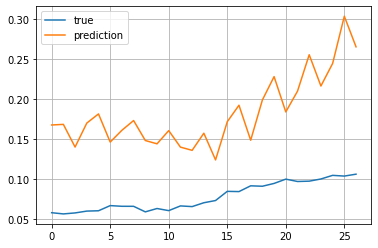

TEST FR-A
MSE =  0.0022655483480639553
MAE =  0.040649526559524744


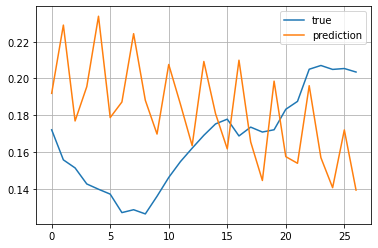

TEST FR-B
MSE =  0.0007811663626592377
MAE =  0.022013912461565387


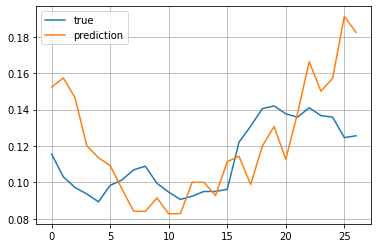

TEST FR-C
MSE =  0.020150868443908808
MAE =  0.12043706786977501


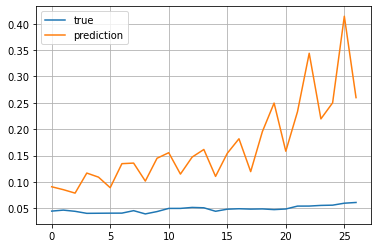

TEST FR-J
MSE =  0.00020596625565271612
MAE =  0.012666132420511402


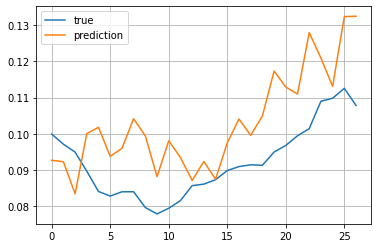

In [281]:
"""for loc in train_datapoints:
    print("TRAINING", loc)
    x, y = train_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()
    
for loc in valid_datapoints:
    print("VALIDATION", loc)
    x, y = valid_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()"""

for loc in test_datapoints:
    MSE = 0
    MAE = 0
    print("TEST", loc)
    x, y = test_datapoints[loc]
    yp = model.predict(x)
    MSE = mean_squared_error(y.reshape(-1), yp.reshape(-1))
    MAE = mean_absolute_error(y.reshape(-1), yp.reshape(-1))
    print("MSE = ", MSE)
    print("MAE = ", MAE)
    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()

In [282]:
# Let's use the validation set

# Base line models
## MultiStepLastBaseline
This model repeats the last value of hospitalisations `n_forecast` time

In [235]:
class MultiStepLastBaseline(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def call(self, inputs):
        a = inputs[:, -1:, :1]  # hospitalisations of the last days
        return tf.tile(
            a,
            [1, n_forecast, 1]   # repeat hospitalisations n_forecast time
        )

BaselineModel = MultiStepLastBaseline()
BaselineModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

## Linear regression
linear regression of the last `n_sample` days used to predict the next `n_forecast` days

In [236]:
class LinearRegressionHospi(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def predict(self, inputs):
        y = inputs[:, :, 0]  # hospitalisations of the last days
        length = len(inputs)
        x = np.arange(n_samples).reshape(-1,1)  # dates of the hospitalisations
        result = np.zeros((length, n_forecast))
        for i in range(length):
            regr = LinearRegression().fit(x,y[i])  # linear regression of (days, hospi)
            result[i] = regr.predict(np.arange(n_samples, n_samples+n_forecast).reshape(-1,1))
        return result
        

## 1 fully connected layer (Dense model)

In [237]:
DenseModel = Sequential()
DenseModel.add(Lambda(lambda x: x[:,:,0]))  # select only the hospitalisations of the previous days
DenseModel.add(Dense(n_forecast))   # predict the next hospitalisations based on the previous ones
DenseModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

In [238]:
LinearModel_history = DenseModel.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=400, verbose=1, shuffle=False, 
          validation_data=validation_generator(),
          validation_steps=len(valid_datapoints))

Epoch 1/400
5/5 [==============================] - 0s 25ms/step - loss: 0.0504 - mean_absolute_error: 0.1226 - val_loss: 0.0275 - val_mean_absolute_error: 0.1413
Epoch 2/400
5/5 [==============================] - 0s 7ms/step - loss: 0.0442 - mean_absolute_error: 0.1056 - val_loss: 0.0218 - val_mean_absolute_error: 0.1222
Epoch 3/400
5/5 [==============================] - 0s 7ms/step - loss: 0.0407 - mean_absolute_error: 0.0951 - val_loss: 0.0178 - val_mean_absolute_error: 0.1074
Epoch 4/400
5/5 [==============================] - 0s 7ms/step - loss: 0.0382 - mean_absolute_error: 0.0873 - val_loss: 0.0149 - val_mean_absolute_error: 0.0957
Epoch 5/400
5/5 [==============================] - 0s 7ms/step - loss: 0.0363 - mean_absolute_error: 0.0815 - val_loss: 0.0127 - val_mean_absolute_error: 0.0865
Epoch 6/400
5/5 [==============================] - 0s 7ms/step - loss: 0.0348 - mean_absolute_error: 0.0774 - val_loss: 0.0110 - val_mean_absolute_error: 0.0793
Epoch 7/400
5/5 [================

5/5 [==============================] - 0s 7ms/step - loss: 0.0122 - mean_absolute_error: 0.0475 - val_loss: 0.0026 - val_mean_absolute_error: 0.0371
Epoch 52/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0120 - mean_absolute_error: 0.0471 - val_loss: 0.0026 - val_mean_absolute_error: 0.0367
Epoch 53/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0118 - mean_absolute_error: 0.0467 - val_loss: 0.0025 - val_mean_absolute_error: 0.0364
Epoch 54/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0116 - mean_absolute_error: 0.0463 - val_loss: 0.0025 - val_mean_absolute_error: 0.0361
Epoch 55/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0114 - mean_absolute_error: 0.0460 - val_loss: 0.0024 - val_mean_absolute_error: 0.0358
Epoch 56/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0113 - mean_absolute_error: 0.0456 - val_loss: 0.0024 - val_mean_absolute_error: 0.0355
Epoch 57/400
5/5 [=======================

5/5 [==============================] - 0s 6ms/step - loss: 0.0066 - mean_absolute_error: 0.0340 - val_loss: 0.0015 - val_mean_absolute_error: 0.0272
Epoch 102/400
5/5 [==============================] - 0s 7ms/step - loss: 0.0066 - mean_absolute_error: 0.0338 - val_loss: 0.0015 - val_mean_absolute_error: 0.0271
Epoch 103/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0065 - mean_absolute_error: 0.0336 - val_loss: 0.0015 - val_mean_absolute_error: 0.0270
Epoch 104/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0064 - mean_absolute_error: 0.0335 - val_loss: 0.0015 - val_mean_absolute_error: 0.0269
Epoch 105/400
5/5 [==============================] - 0s 7ms/step - loss: 0.0064 - mean_absolute_error: 0.0333 - val_loss: 0.0014 - val_mean_absolute_error: 0.0268
Epoch 106/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0063 - mean_absolute_error: 0.0331 - val_loss: 0.0014 - val_mean_absolute_error: 0.0267
Epoch 107/400
5/5 [=================

5/5 [==============================] - 0s 7ms/step - loss: 0.0041 - mean_absolute_error: 0.0272 - val_loss: 0.0011 - val_mean_absolute_error: 0.0232
Epoch 152/400
5/5 [==============================] - 0s 7ms/step - loss: 0.0041 - mean_absolute_error: 0.0271 - val_loss: 0.0011 - val_mean_absolute_error: 0.0232
Epoch 153/400
5/5 [==============================] - 0s 7ms/step - loss: 0.0041 - mean_absolute_error: 0.0270 - val_loss: 0.0011 - val_mean_absolute_error: 0.0231
Epoch 154/400
5/5 [==============================] - 0s 7ms/step - loss: 0.0040 - mean_absolute_error: 0.0269 - val_loss: 0.0011 - val_mean_absolute_error: 0.0231
Epoch 155/400
5/5 [==============================] - 0s 22ms/step - loss: 0.0040 - mean_absolute_error: 0.0268 - val_loss: 0.0011 - val_mean_absolute_error: 0.0230
Epoch 156/400
5/5 [==============================] - 0s 15ms/step - loss: 0.0040 - mean_absolute_error: 0.0267 - val_loss: 0.0011 - val_mean_absolute_error: 0.0230
Epoch 157/400
5/5 [===============

5/5 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_absolute_error: 0.0234 - val_loss: 9.2889e-04 - val_mean_absolute_error: 0.0216
Epoch 201/400
5/5 [==============================] - 0s 10ms/step - loss: 0.0030 - mean_absolute_error: 0.0234 - val_loss: 9.2721e-04 - val_mean_absolute_error: 0.0215
Epoch 202/400
5/5 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_absolute_error: 0.0233 - val_loss: 9.2557e-04 - val_mean_absolute_error: 0.0215
Epoch 203/400
5/5 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_absolute_error: 0.0232 - val_loss: 9.2397e-04 - val_mean_absolute_error: 0.0215
Epoch 204/400
5/5 [==============================] - 0s 10ms/step - loss: 0.0029 - mean_absolute_error: 0.0232 - val_loss: 9.2241e-04 - val_mean_absolute_error: 0.0215
Epoch 205/400
5/5 [==============================] - 0s 11ms/step - loss: 0.0029 - mean_absolute_error: 0.0231 - val_loss: 9.2089e-04 - val_mean_absolute_error: 0.0215
Epoch 206

5/5 [==============================] - 0s 7ms/step - loss: 0.0025 - mean_absolute_error: 0.0213 - val_loss: 8.7880e-04 - val_mean_absolute_error: 0.0211
Epoch 250/400
5/5 [==============================] - 0s 9ms/step - loss: 0.0025 - mean_absolute_error: 0.0213 - val_loss: 8.7823e-04 - val_mean_absolute_error: 0.0210
Epoch 251/400
5/5 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_absolute_error: 0.0212 - val_loss: 8.7766e-04 - val_mean_absolute_error: 0.0210
Epoch 252/400
5/5 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0212 - val_loss: 8.7711e-04 - val_mean_absolute_error: 0.0210
Epoch 253/400
5/5 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_absolute_error: 0.0212 - val_loss: 8.7656e-04 - val_mean_absolute_error: 0.0210
Epoch 254/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0024 - mean_absolute_error: 0.0212 - val_loss: 8.7603e-04 - val_mean_absolute_error: 0.0210
Epoch 255/4

5/5 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_absolute_error: 0.0202 - val_loss: 8.5933e-04 - val_mean_absolute_error: 0.0208
Epoch 299/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_absolute_error: 0.0202 - val_loss: 8.5905e-04 - val_mean_absolute_error: 0.0208
Epoch 300/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_absolute_error: 0.0202 - val_loss: 8.5877e-04 - val_mean_absolute_error: 0.0208
Epoch 301/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_absolute_error: 0.0202 - val_loss: 8.5850e-04 - val_mean_absolute_error: 0.0208
Epoch 302/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_absolute_error: 0.0202 - val_loss: 8.5824e-04 - val_mean_absolute_error: 0.0208
Epoch 303/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0022 - mean_absolute_error: 0.0202 - val_loss: 8.5797e-04 - val_mean_absolute_error: 0.0208
Epoch 304/40

5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0196 - val_loss: 8.4812e-04 - val_mean_absolute_error: 0.0206
Epoch 348/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0196 - val_loss: 8.4793e-04 - val_mean_absolute_error: 0.0206
Epoch 349/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0196 - val_loss: 8.4773e-04 - val_mean_absolute_error: 0.0206
Epoch 350/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0196 - val_loss: 8.4754e-04 - val_mean_absolute_error: 0.0206
Epoch 351/400
5/5 [==============================] - 0s 7ms/step - loss: 0.0021 - mean_absolute_error: 0.0196 - val_loss: 8.4735e-04 - val_mean_absolute_error: 0.0206
Epoch 352/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0196 - val_loss: 8.4716e-04 - val_mean_absolute_error: 0.0206
Epoch 353/40

5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0192 - val_loss: 8.3931e-04 - val_mean_absolute_error: 0.0205
Epoch 397/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0192 - val_loss: 8.3914e-04 - val_mean_absolute_error: 0.0205
Epoch 398/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0192 - val_loss: 8.3897e-04 - val_mean_absolute_error: 0.0205
Epoch 399/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0192 - val_loss: 8.3880e-04 - val_mean_absolute_error: 0.0205
Epoch 400/400
5/5 [==============================] - 0s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0192 - val_loss: 8.3864e-04 - val_mean_absolute_error: 0.0205


# Comparisons of the models

In [283]:
#LSTMModel = scan_object.best_model(metric='val_mse', asc=True)  # retrieve the best model from the scan
all_models = {
    'RepeatLast': BaselineModel,
    'LSTM': LSTMModel,
    'Dense': DenseModel,
    'Linear regression': LinearRegressionHospi()
}

def error_set(models, points, plot=True):
    y_predicted = {k:[] for k in models.keys()}
    y_true = []
    length = 0
    for loc in points:
        print(loc)
        length += 1
        x, y = points[loc]
        y = y.reshape(-1)
        y_true.extend(y)
        for name, model in models.items():
            yp = model.predict(x)
            yp = yp.reshape(-1)
            if plot:
                plt.plot(y, label='true')
                plt.plot(yp, label='prediction')
                plt.legend()
                plt.grid()
                plt.title(name)
                plt.show()
            y_predicted[name].extend(yp)
    MSE = []
    MAE = []
    models_names = []
    for k in models.keys():
        models_names.append(k)
        MSE.append(mean_squared_error(y_true, y_predicted[k]))
        MAE.append(mean_absolute_error(y_true, y_predicted[k]))
    return pd.DataFrame(data={'Model': models_names, 'MSE': MSE, 'MAE': MAE}).set_index('Model').sort_values(by=['MSE'])

## Training

In [284]:
error_set(all_models, train_datapoints, plot=False)

BE
FR-A
FR-B
FR-C
FR-J


,MSE,MAE
Model,,
LSTM,0.000172,0.009627
Dense,0.003255,0.024269
RepeatLast,0.003770,0.024406
Linear regression,0.014601,0.049956


## Validation

BE


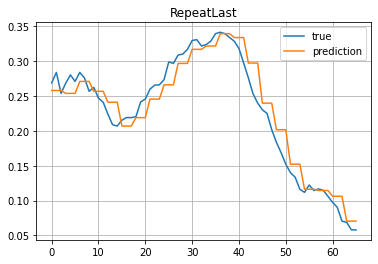

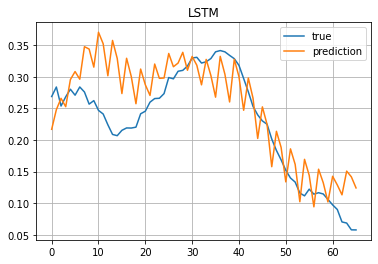

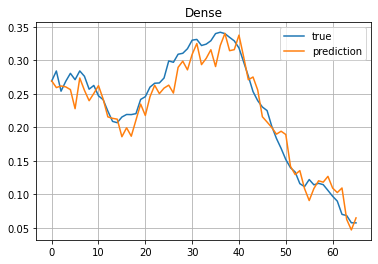

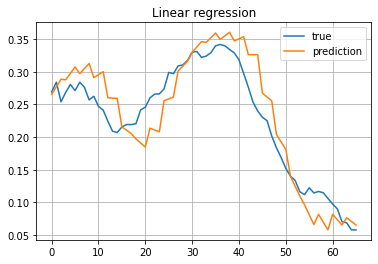

FR-A


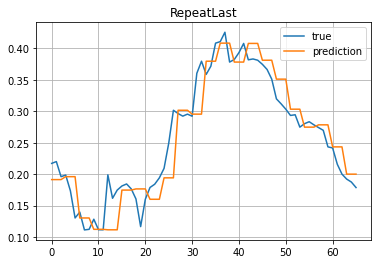

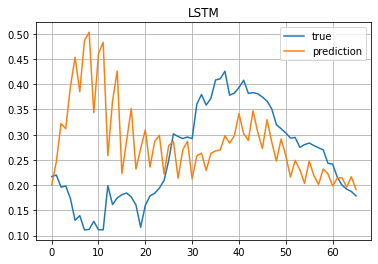

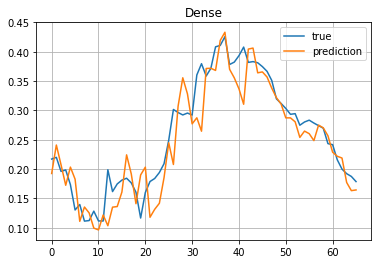

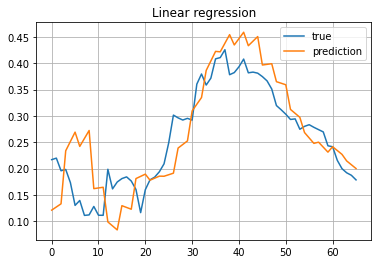

FR-B


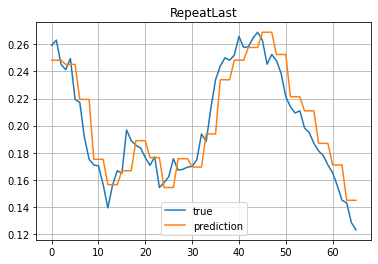

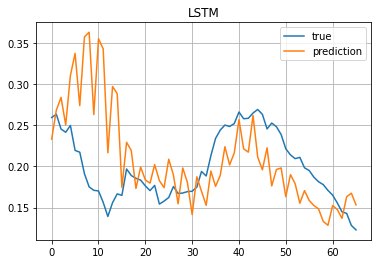

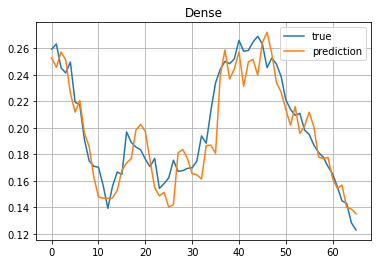

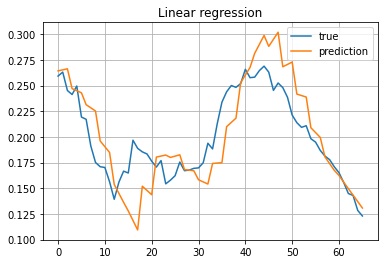

FR-C


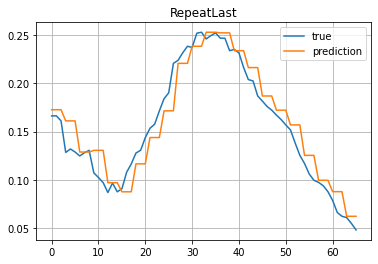

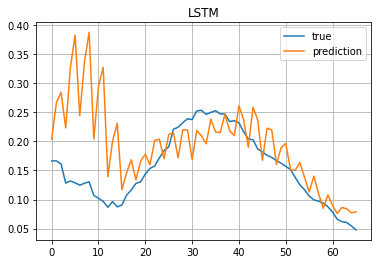

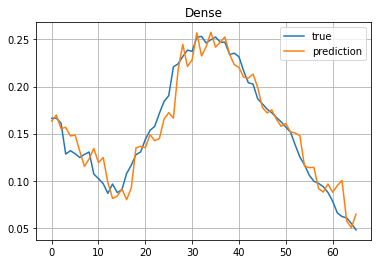

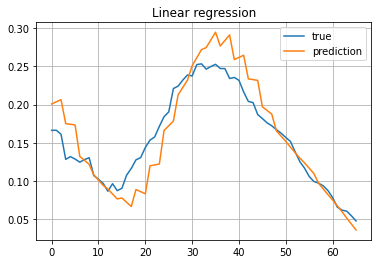

FR-J


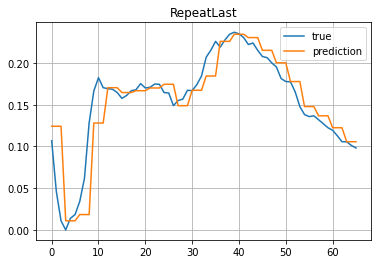

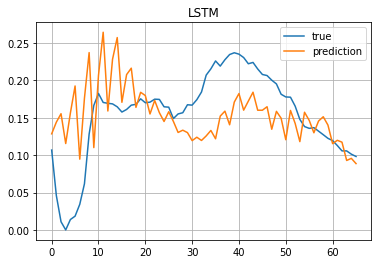

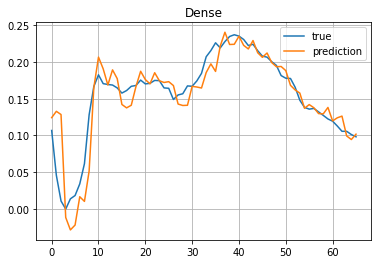

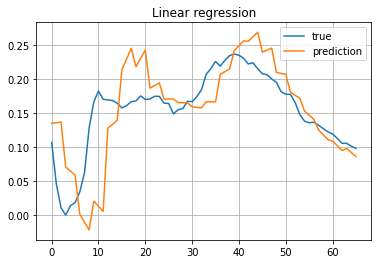

,MSE,MAE
Model,,
RepeatLast,0.000561,0.016590
Dense,0.000592,0.016775
Linear regression,0.001815,0.031233
LSTM,0.007385,0.058343


In [285]:
error_set(all_models, valid_datapoints)

## Test

BE


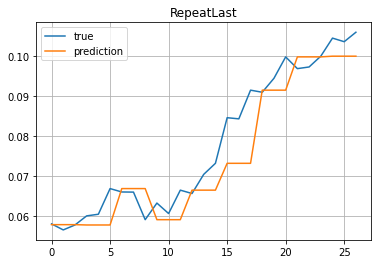

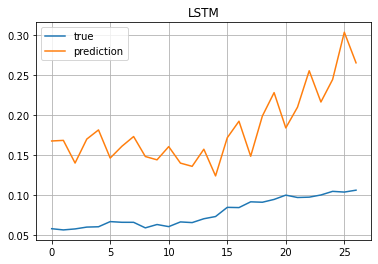

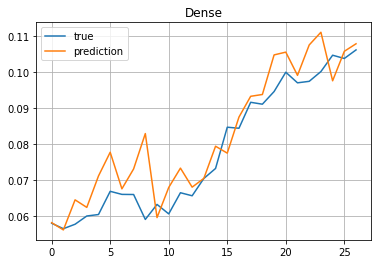

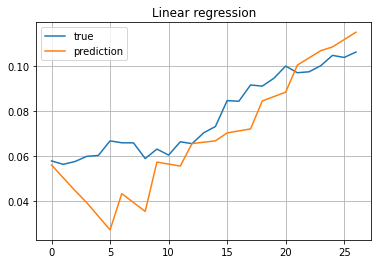

FR-A


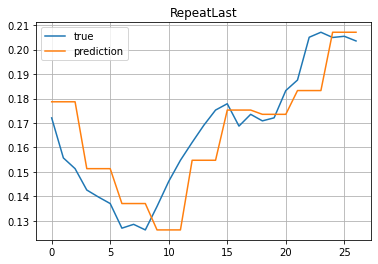

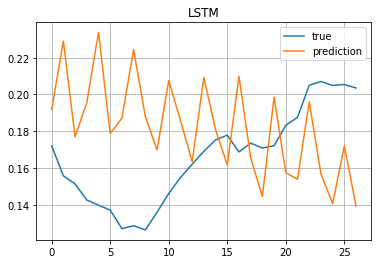

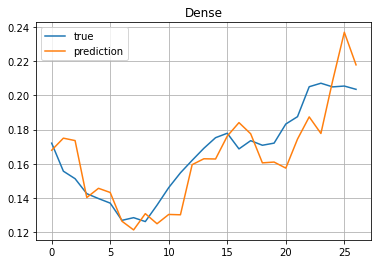

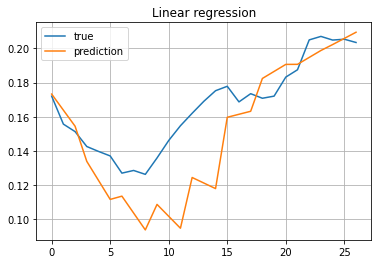

FR-B


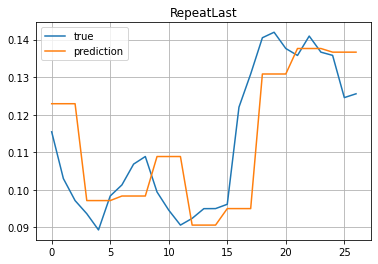

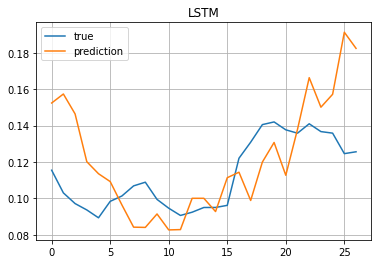

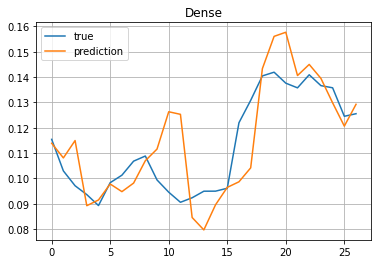

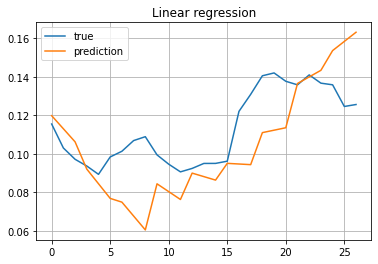

FR-C


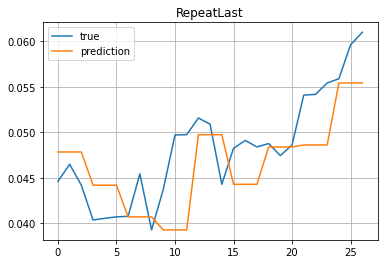

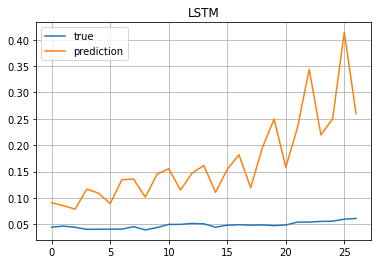

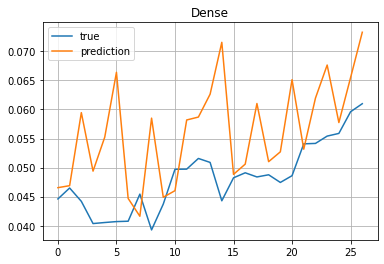

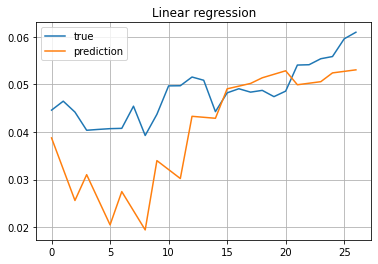

FR-J


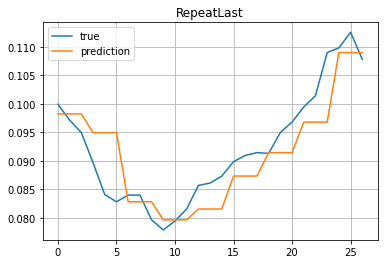

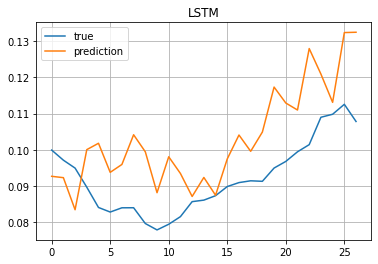

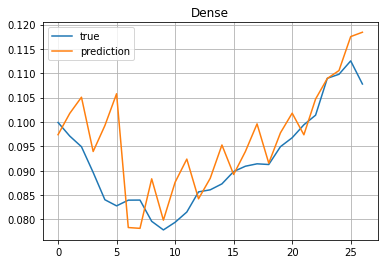

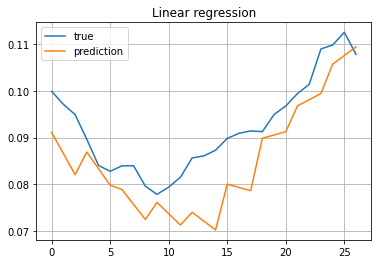

,MSE,MAE
Model,,
RepeatLast,0.000090,0.006604
Dense,0.000131,0.008389
Linear regression,0.000313,0.012898
LSTM,0.007085,0.060118


In [286]:
error_set(all_models, test_datapoints)